## Comaprison of different standard models in sci-kit to find exoplanets using Nasa K2 DB

In [92]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("k2pandc_2025.10.02_03.11.29.csv", comment="#")
df_filtered = df[~df["disposition"].isin(["CANDIDATE", "REFUTED"])]
df = df_filtered
df = df.sort_values("releasedate").drop_duplicates(subset=["pl_name"], keep="last")
df


,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
109,EPIC 201555883.01,EPIC 201555883,1,FALSE POSITIVE,Montet et al. 2015,1.0,0.0,Transit,2015.0,K2,...,-0.092,12.431,0.030,-0.030,15.0199,0.001299,-0.001299,2015-12-05,2015-08,2015-12-05
118,EPIC 201569483.01,EPIC 201569483,0,FALSE POSITIVE,Montet et al. 2015,1.0,0.0,Transit,2015.0,K2,...,-0.038,9.883,0.023,-0.023,11.7062,0.001189,-0.001189,2015-12-05,2015-08,2015-12-05
148,EPIC 201649426.01,EPIC 201649426,0,FALSE POSITIVE,Montet et al. 2015,1.0,0.0,Transit,2015.0,K2,...,-0.160,10.941,0.019,-0.019,13.2049,0.000291,-0.000291,2015-12-05,2015-08,2015-12-05
56,EPIC 201257461.01,EPIC 201257461,1,FALSE POSITIVE,Montet et al. 2015,1.0,0.0,Transit,2015.0,K2,...,-0.033,9.368,0.023,-0.023,11.5044,0.000606,-0.000606,2015-12-05,2016-01,2015-12-05
209,EPIC 201929294.01,EPIC 201929294,1,FALSE POSITIVE,Montet et al. 2015,1.0,0.0,Transit,2015.0,K2,...,-0.092,10.798,0.021,-0.021,13.0277,0.002001,-0.002001,2015-12-05,2015-08,2015-12-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,WASP-118 b,WASP-118,0,CONFIRMED,Hay et al. 2016,1.0,1.0,Transit,2016.0,SuperWASP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3908,WASP-151 b,WASP-151,1,CONFIRMED,Demangeon et al. 2018,1.0,1.0,Transit,2017.0,SuperWASP-South,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3917,WASP-157 b,WASP-157,0,CONFIRMED,Mo&,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3923,WASP-28 b,WASP-28,1,CONFIRMED,Petrucci et al. 2015,1.0,1.0,Transit,2014.0,SuperWASP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We start from excluding candidates/refuted, beacuse they won't help in learnig for our model.

Now we'll try to figure out which features can be somehow helpful

In [93]:
features = [
    "sy_snum", "sy_pnum",
    "pl_orbper", "pl_orbsmax",
    "pl_rade", "pl_radj",
    "pl_bmasse", "pl_bmassj",
    "pl_orbeccen", "pl_insol", "pl_eqt",
    "st_teff", "st_rad", "st_mass", "st_met", "st_logg",
    "ra", "dec", "sy_dist", "sy_vmag", "sy_kmag", "sy_gaiamag"
]

These are all features that are numerical and might offer something.
Now we have to prepare our X,y

In [94]:
X = df.filter(items=features)
y = df["disposition"]
y

109     FALSE POSITIVE
118     FALSE POSITIVE
148     FALSE POSITIVE
56      FALSE POSITIVE
209     FALSE POSITIVE
             ...      
3901         CONFIRMED
3908         CONFIRMED
3917         CONFIRMED
3923         CONFIRMED
3999         CONFIRMED
Name: disposition, Length: 822, dtype: object

We can see that we have a lot of NaN in our DB, so we'll try to change them to median values, so they won't have any influence on our data

In [95]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,...,st_rad,st_mass,st_met,st_logg,ra,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag
0,1.0,0.0,6.034000,0.0677,2.29,0.204300,9.75,0.030677,0.11,100.0,...,0.520000,0.88,-0.98,4.47,176.075851,1.375963,527.641,15.484,12.431,15.0199
1,1.0,0.0,5.796870,0.0677,27.81,2.481000,9.75,0.030677,0.11,100.0,...,0.790000,0.88,-0.09,4.47,167.171199,1.577449,233.550,12.329,9.883,11.7062
2,1.0,0.0,27.770450,0.0677,32.79,2.925000,9.75,0.030677,0.11,100.0,...,8.150000,0.88,-0.17,4.47,177.234392,2.807564,252.383,13.595,10.941,13.2049
3,1.0,0.0,50.285869,0.0677,3.47,0.309573,9.75,0.030677,0.11,100.0,...,0.740000,0.88,-0.03,4.47,178.161126,-3.094909,829.248,11.668,9.368,11.5044
4,1.0,0.0,6.034000,0.0677,2.29,0.204300,9.75,0.030677,0.11,100.0,...,0.700000,0.88,-0.16,4.47,174.656940,7.959563,2140.250,13.360,10.798,13.0277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,1.0,1.0,6.034000,0.0677,2.29,0.204300,9.75,0.030677,0.11,100.0,...,0.889674,0.88,-0.03,4.47,140.445148,5.306478,265.914,13.074,10.859,12.8153
818,1.0,1.0,6.034000,0.0677,2.29,0.204300,9.75,0.030677,0.11,100.0,...,0.889674,0.88,-0.03,4.47,140.445148,5.306478,265.914,13.074,10.859,12.8153
819,1.0,1.0,6.034000,0.0677,2.29,0.204300,9.75,0.030677,0.11,100.0,...,0.889674,0.88,-0.03,4.47,140.445148,5.306478,265.914,13.074,10.859,12.8153
820,1.0,1.0,6.034000,0.0677,2.29,0.204300,9.75,0.030677,0.11,100.0,...,0.889674,0.88,-0.03,4.47,140.445148,5.306478,265.914,13.074,10.859,12.8153


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Dokładność na zbiorze testowym:", model.score(X_test, y_test))

Dokładność na zbiorze testowym: 1.0


In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_test, y_pred, pos_label="FALSE POSITIVE")
recall = recall_score(y_test, y_pred, pos_label="FALSE POSITIVE")
f1 = f1_score(y_test, y_pred, pos_label="FALSE POSITIVE")

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

Precision: 1.000, Recall: 1.000, F1: 1.000


Now we want to show which of our features matters most

In [98]:
fi = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importance (RandomForest):")
print(fi.sort_values(ascending=False))


Feature Importance (RandomForest):
sy_pnum        0.465014
pl_orbper      0.095100
pl_radj        0.069875
pl_rade        0.060260
sy_dist        0.055109
st_rad         0.049198
dec            0.043890
sy_kmag        0.031629
st_teff        0.025040
st_logg        0.022323
ra             0.019380
sy_gaiamag     0.014994
pl_eqt         0.011170
st_mass        0.009834
sy_vmag        0.008678
st_met         0.005041
pl_insol       0.004088
pl_bmasse      0.002855
pl_orbsmax     0.002626
pl_bmassj      0.002286
pl_orbeccen    0.001557
sy_snum        0.000053
dtype: float64


we can see that sy_pnum was the most important one

In [99]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[290   0]
 [  0 121]]
                precision    recall  f1-score   support

     CONFIRMED       1.00      1.00      1.00       290
FALSE POSITIVE       1.00      1.00      1.00       121

      accuracy                           1.00       411
     macro avg       1.00      1.00      1.00       411
  weighted avg       1.00      1.00      1.00       411



Small DB might give us better results than they actually are but this is still not bad model

Now we'll try using KN_neighbours

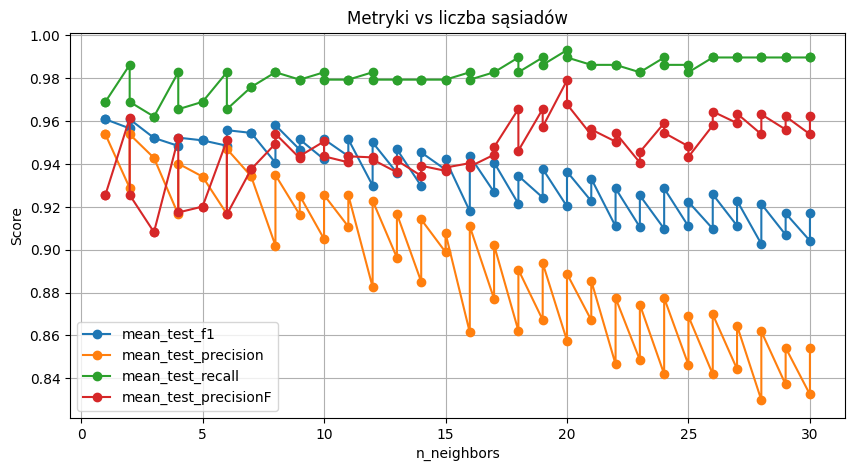

In [100]:
from sklearn.metrics import make_scorer

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("estimator", KNeighborsClassifier()),
])

param_grid = {
    "estimator__n_neighbors": range(1, 31),
    "estimator__weights": ["uniform", "distance"],
}

scoring = {
    "f1": make_scorer(f1_score, pos_label="CONFIRMED"),
    "precision": make_scorer(precision_score, pos_label="CONFIRMED"),
    "recall": make_scorer(recall_score, pos_label="CONFIRMED"),
    "precisionF" : make_scorer(precision_score, pos_label="FALSE POSITIVE"),
}



grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    cv=5,
    refit="precisionF",
)

grid.fit(X_train, y_train)

import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results = results.set_index("param_estimator__n_neighbors")  # prefiks zgodny z nazwą kroku
metrics = ["mean_test_f1", "mean_test_precision", "mean_test_recall", "mean_test_precisionF"]

plot_data = results[metrics]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for metric in metrics:
    plt.plot(plot_data.index, plot_data[metric], marker='o', label=metric)

plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.title("Metryki vs liczba sąsiadów")
plt.legend()
plt.grid(True)
plt.show()